In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
Width = 256
Height = 256
K = 20

category = ['Aeroplanes', 'Bicycles', 'Birds', 'Boats', 'Bottles', 
            'Buses', 'Cars', 'Cats', 'Chairs', 'Cows', 
            'Dining tables', 'Dogs', 'Horses', 'Motorbikes', 'People',
            'Potted plants', 'Sheep', 'Sofas',  'Trains', 'TV/Monitors']

In [4]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((Height, Width)),
    transforms.ToTensor(),
    ])

target_transform = transforms.Compose([
    transforms.Resize((Height, Width)),
    transforms.ToTensor(),
    lambda x: (x[0] * 255).long(),
    ])


# choose the training and test datasets
train_data = datasets.VOCSegmentation(root='voc', year='2012', image_set='train', 
                                      download=True, 
                                      transform=transform, 
                                      target_transform=target_transform)
print(train_data)

test_data = datasets.VOCSegmentation(root='voc', year='2012', image_set='val', 
                                     download=True, 
                                     transform=transform, 
                                     target_transform=target_transform)
print(test_data)

Using downloaded and verified file: voc/VOCtrainval_06-Nov-2007.tar
Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: voc
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Target transform: Compose(
                      Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
                      ToTensor()
                      <function <lambda> at 0x7f8e0c1c77a0>
                  )
Using downloaded and verified file: voc/VOCtrainval_06-Nov-2007.tar
Dataset VOCSegmentation
    Number of datapoints: 213
    Root location: voc
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Target transform: Compose(
                      Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
                      ToTensor()
                      <function <lambda> a

In [5]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=1)
print(train_loader)
print(test_loader)

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

In [7]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                     kernel_size=kernel_size, stride=1, padding=padding, bias=False)
        
    def forward(self, x):
        x = self.conv(x)
        return x
            
class DownConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                                                  out_channels=hidden_channels, 
                                                                  kernel_size=2, stride=2, bias=False),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),

                                          nn.Sequential(nn.Conv2d(in_channels=hidden_channels, 
                                                                  out_channels=hidden_channels,
                                                                  kernel_size=3, padding=1),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                                        
                                          nn.Conv2d(in_channels=hidden_channels, 
                                                    out_channels=out_channels, 
                                                    kernel_size=1)])
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, out_channels=hidden_channels, 
                                                                           kernel_size=2, stride=2, bias=False),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                         
                                          nn.Sequential(nn.Conv2d(in_channels=hidden_channels, 
                                                                  out_channels=hidden_channels,
                                                                  kernel_size=3, padding=1),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                                        
                                          nn.Conv2d(in_channels=hidden_channels, 
                                                    out_channels=out_channels, 
                                                    kernel_size=1)])
    
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        
        return x
        
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Unet

        self.prenet = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1)
        
        self.downs = nn.ModuleList([DownConv(16, 32, 16),
                                    DownConv(16, 64, 32),
                                    DownConv(32, 128, 64),
                                    DownConv(64, 256, 128),
                                    DownConv(128, 512, 256)])
             
        self.ups = nn.ModuleList([UpConv(256, 512, 128),
                                  UpConv(256, 512, 64),
                                  UpConv(128, 256, 32),
                                  UpConv(64, 128, 16),
                                  UpConv(32, 64, 16)])
        
        self.postnet = nn.Conv2d(in_channels=16, out_channels=K, kernel_size=3, padding=1)
        
    def forward(self, x):
        # x : (b, c, h, w)
        
        xs = []
        # 1
        x = self.prenet(x)
        xs.append(x)
        # 1/2, 1/4, 1/8, 1/16
        for i, down in enumerate(self.downs):
            x = down(x)
            xs.append(x)
        
        x = None
        outputs = []
        for up in self.ups:
            if x is None:
                x = xs.pop()
            else:
                x = torch.cat([x, xs.pop()], dim=1)
            
            x = up(x)
        
        x = self.postnet(x)
        
        return x
    
print('done')

done


In [8]:
model = Unet().cuda()
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

def sizeof_fmt(num, suffix='B'):
    """
    Given `num` bytes, return human readable size.
    Taken from https://stackoverflow.com/a/1094933
    """
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

Model size 40.0MiB


1.Aeroplanes 2.Bicycles 3.Birds 4.Boats 5.Bottles 6.Buses 7.Cars 8.Cats 9.Chairs 10.Cows 11.Dining tables 12.Dogs 13.Horses 14.Motorbikes 15.People 16.Potted plants 17.Sheep 18.Sofas 19.Trains 20.TV/Monitors 


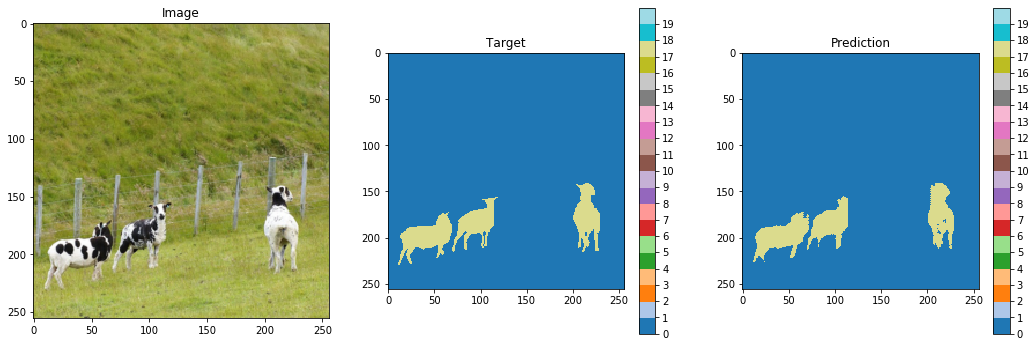

KeyboardInterrupt: 

In [18]:
from IPython import display
import matplotlib.pyplot as plt

step = 0

while(True):
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        y[torch.where(y==255)] = 0

        model.train()
        model.zero_grad()
        o = model(x)
        
        loss = nn.CrossEntropyLoss()(o, y)
        loss.backward()        
        optimizer.step()
        
        if step % 20 == 0:
            print('step:', step, 'loss:', loss.item())
        
        if step % 100 == 0:
            display.clear_output()
            
            string = ''
            for index, cat in enumerate(category):
                string += str(index+1) + '.' + cat + ' '
            print(string)
            
            for batch_index in range(3):
                plt.figure(figsize=[18, 6])
                plt.subplot(1, 3, 1)
                plt.title('Image')
                _x = x[batch_index].data.cpu().numpy()
                plt.imshow(_x.transpose(1, 2, 0))

                plt.subplot(1, 3, 2)
                plt.title('Target')
                _y = y[batch_index].data.cpu().numpy()
                plt.imshow(_y, vmin=0, vmax=20, cmap='tab20')
                plt.colorbar(ticks=np.arange(0, 20))

                plt.subplot(1, 3, 3)
                plt.title('Prediction')
                _o = torch.argmax(o[batch_index], dim=0)
                _o = _o.data.cpu().numpy()
                plt.imshow(_o, vmin=0, vmax=20, cmap='tab20')
                plt.colorbar(ticks=np.arange(0, 20))
                plt.show()
            
        step += 1
        